# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
#train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
train_dataset_path='D:/DatasetMedicalWasteCroppedBalancedOversamplingCopying/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15342 files belonging to 41 classes.
Using 12274 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15342 files belonging to 41 classes.
Using 3068 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


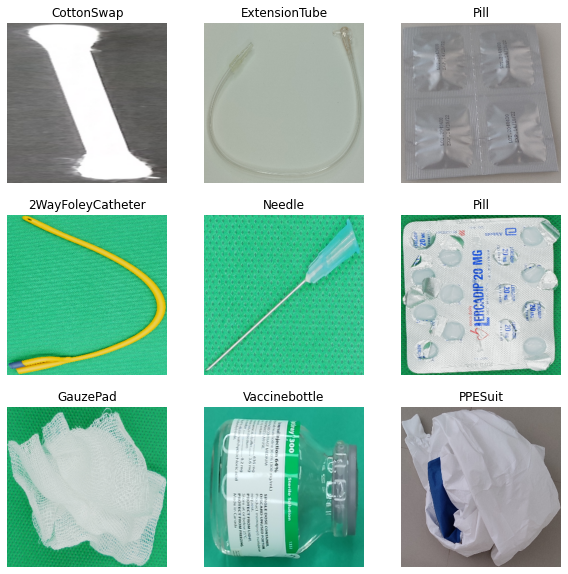

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)


## Freez Extractor+

In [18]:
custom_inceptionv3_model.trainable = False
for layer in custom_inceptionv3_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 41)                84009     
Total params: 21,886,793
Trainable params: 84,009
Non-trainable params: 21,802,784
_________________________________________________________________


# Fitting

In [21]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-Oversampling-NoAug-VerySlowLR/'

In [22]:
EPOCHS = 2000
save_model_interval = 40
checkpoint_filepath = path_to_model+'OurOutputLayer-Oversampling-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
192/192 [==============================] - 152s 303ms/step - loss: 0.8069 - accuracy: 0.8467 - val_loss: 0.2073 - val_accuracy: 0.9759
Epoch 2/2000
192/192 [==============================] - 34s 178ms/step - loss: 0.1446 - accuracy: 0.9817 - val_loss: 0.0983 - val_accuracy: 0.9909
Epoch 3/2000
192/192 [==============================] - 34s 178ms/step - loss: 0.0775 - accuracy: 0.9926 - val_loss: 0.0626 - val_accuracy: 0.9938
Epoch 4/2000
192/192 [==============================] - 34s 178ms/step - loss: 0.0502 - accuracy: 0.9963 - val_loss: 0.0449 - val_accuracy: 0.9954
Epoch 5/2000
192/192 [==============================] - 34s 178ms/step - loss: 0.0357 - accuracy: 0.9978 - val_loss: 0.0345 - val_accuracy: 0.9971
Epoch 6/2000
192/192 [==============================] - 34s 178ms/step - loss: 0.0269 - accuracy: 0.9989 - val_loss: 0.0276 - val_accuracy: 0.9974
Epoch 7/2000
192/192 [==============================] - 34s 178ms/step - loss: 0.0212 - accuracy: 0.9993 - val_loss: 

Text(0.5, 1.0, 'Training and Validation Accuracy')

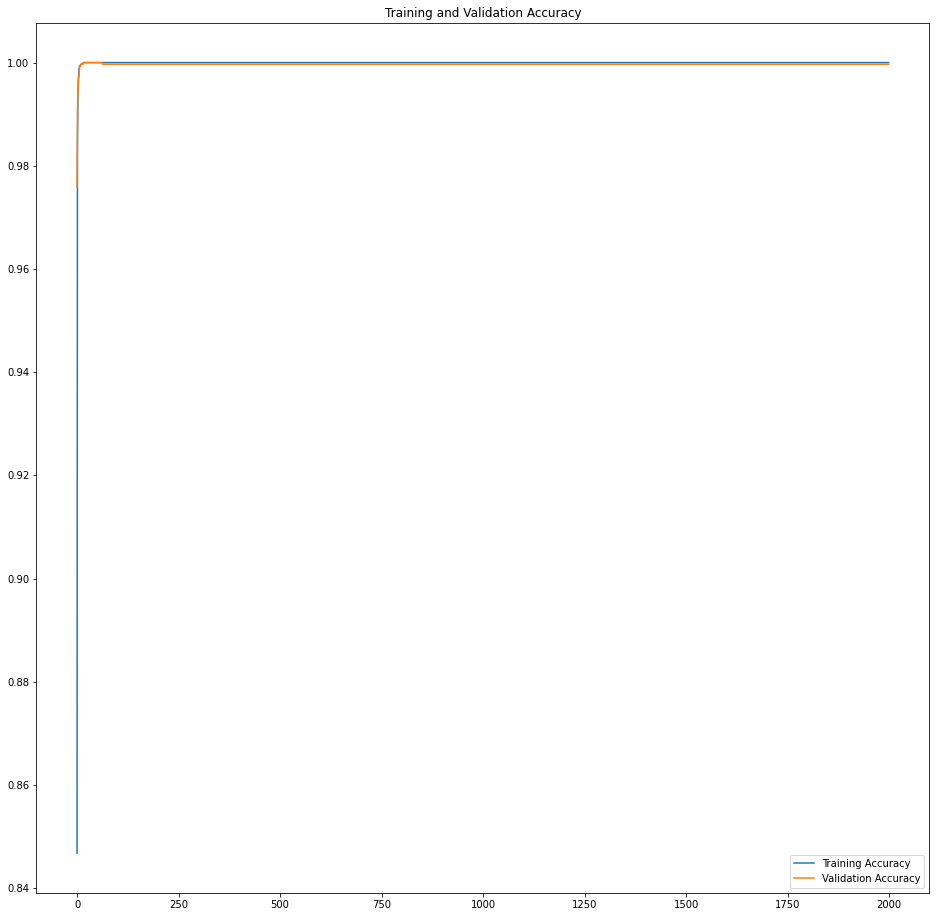

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


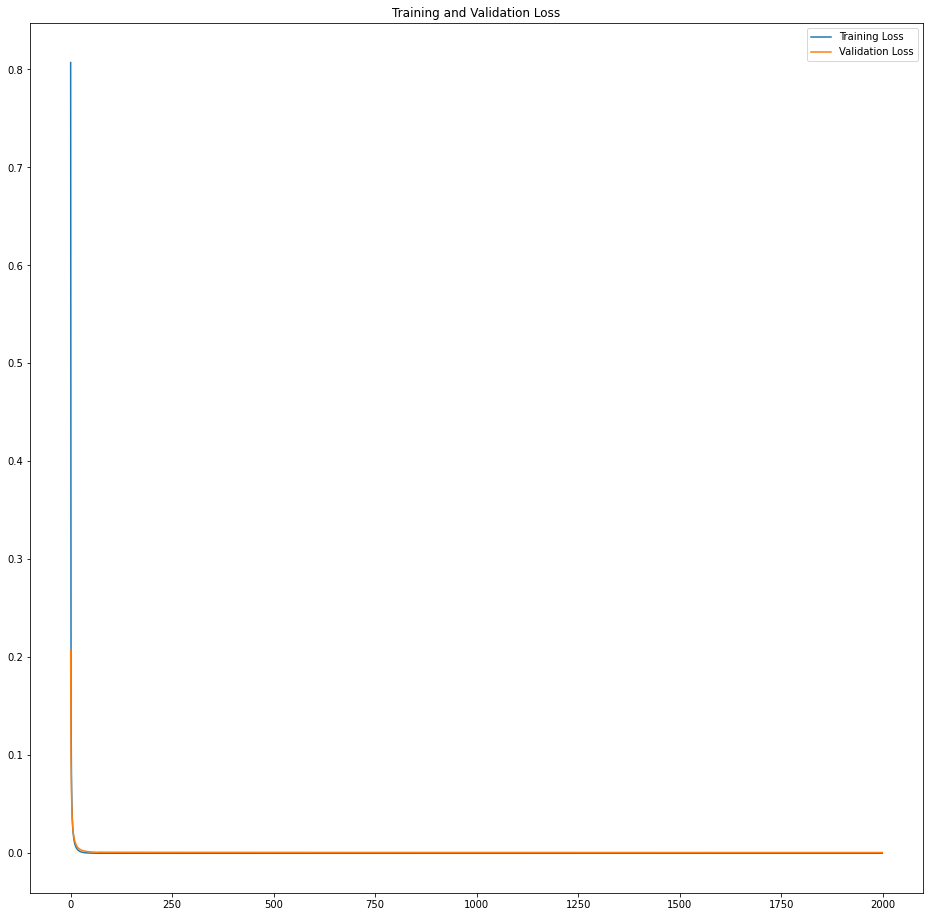

In [24]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 15s 357ms/step - loss: 0.7318 - accuracy: 0.8629
test_indoor_ds_results:test loss, test acc: [0.7317705750465393, 0.8628762364387512]


In [26]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 28s 461ms/step - loss: 2.1244 - accuracy: 0.7500
test_outdoor_ds_results:test loss, test acc: [2.1243813037872314, 0.75]


In [27]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 9s 216ms/step - loss: 2.2044 - accuracy: 0.7108
test_belt_ds_results:test loss, test acc: [2.204383134841919, 0.7107887864112854]


In [28]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-Oversampling-NoAug-VerySlowLR/OurOutputLayer-Oversampling-NoAug-epoch0040-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-Oversampling-NoAug-VerySlowLR/OurOutputLayer-Oversampling-NoAug-epoch0080-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-Oversampling-NoAug-VerySlowLR/OurOutputLayer-Oversampling-NoAug-epoch0120-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-Oversampling-NoAug-VerySlowLR/OurOutputLayer-Oversampling-NoAug-epoch0160-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-Oversampling-NoAug-VerySlowLR/OurOutputLayer-Oversampling-NoAug-epoch0200-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-Oversampling-NoAug-VerySlowLR/OurOutputLayer-Oversampling-NoAug-epoch0240-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/I

# Testing in testset

In [29]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 138ms/step - loss: 1.4484 - accuracy: 0.7076
Epoch040 
 test_indoor_acc=0.8729097247123718 
 test_outdoor_acc=0.7509554028511047 
 test_belt_acc=0.7076156139373779
35/35 [==============================] - 5s 139ms/step - loss: 1.7476 - accuracy: 0.7126
Epoch080 
 test_indoor_acc=0.8690078258514404 
 test_outdoor_acc=0.752866268157959 
 test_belt_acc=0.7126020193099976
35/35 [==============================] - 5s 137ms/step - loss: 1.7707 - accuracy: 0.7126
Epoch120 
 test_indoor_acc=0.8690078258514404 
 test_outdoor_acc=0.7538216710090637 
 test_belt_acc=0.7126020193099976
35/35 [==============================] - 5s 136ms/step - loss: 1.8029 - accuracy: 0.7121
Epoch160 
 test_indoor_acc=0.868450403213501 
 test_outdoor_acc=0.7541401386260986 
 test_belt_acc=0.7121486663818359
35/35 [==============================] - 5s 138ms/step - loss: 1.8319 - accuracy: 0.7121
Epoch200 
 test_indoor_acc=0.8690078258514404 
 test_outdoor_acc=0.75382167100906

In [30]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(40, 2040, 40)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

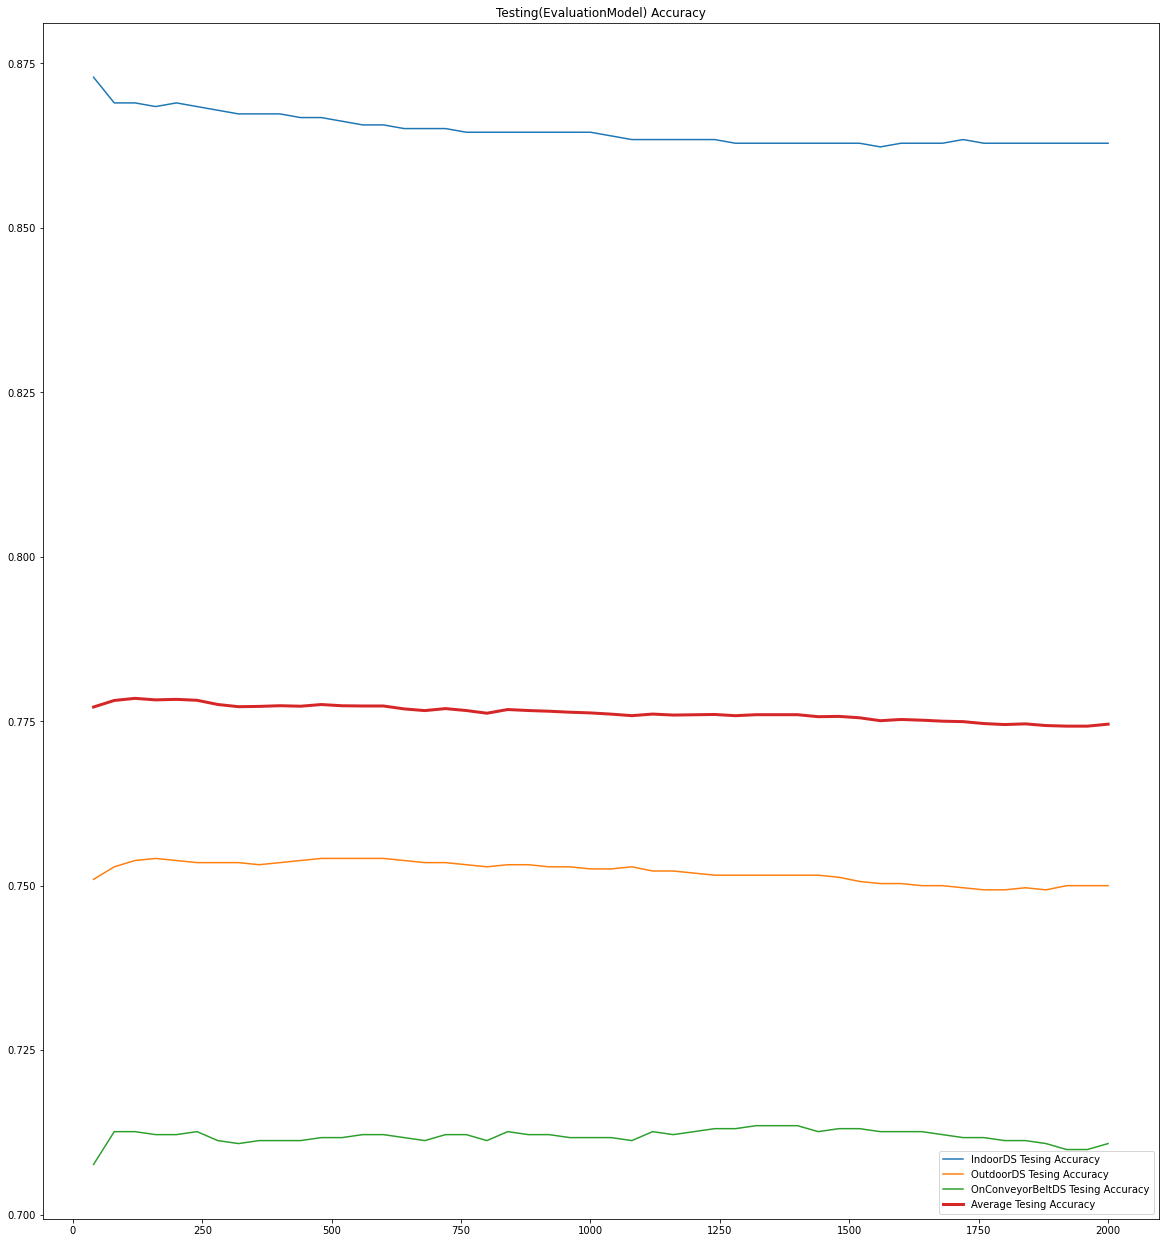

In [31]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

In [32]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.7784771720568339
max index -> 2
The [Epoch] of max acc -> 120


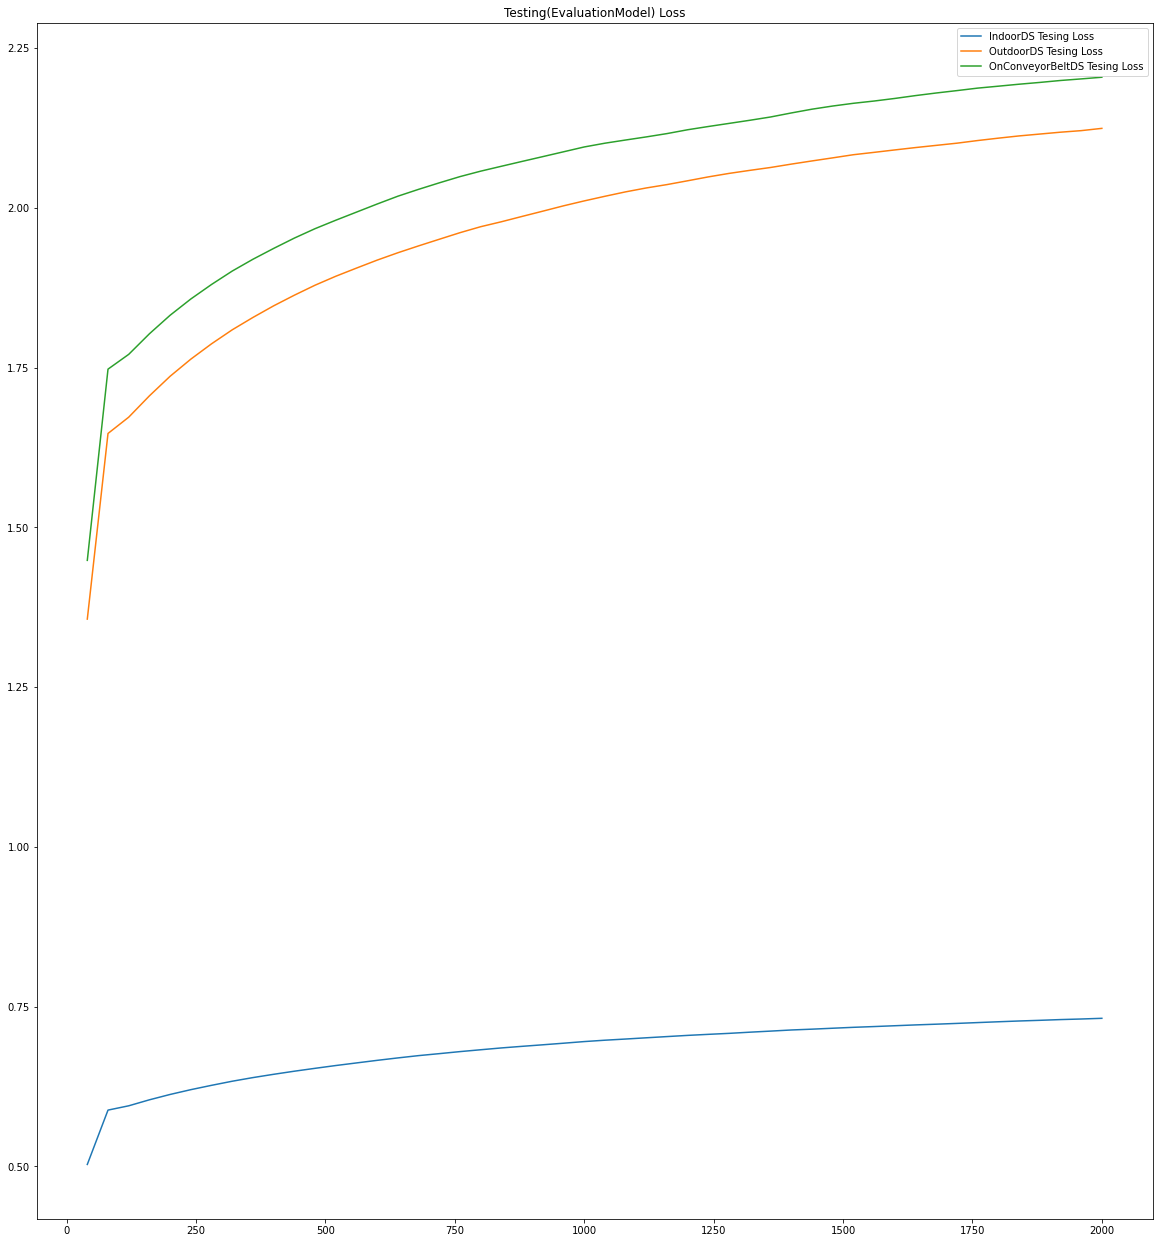

In [33]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [34]:
test_indoor_acc

[0.8729097247123718,
 0.8690078258514404,
 0.8690078258514404,
 0.868450403213501,
 0.8690078258514404,
 0.868450403213501,
 0.8678929805755615,
 0.8673355579376221,
 0.8673355579376221,
 0.8673355579376221,
 0.8667781352996826,
 0.8667781352996826,
 0.8662207126617432,
 0.8656633496284485,
 0.8656633496284485,
 0.865105926990509,
 0.865105926990509,
 0.865105926990509,
 0.8645485043525696,
 0.8645485043525696,
 0.8645485043525696,
 0.8645485043525696,
 0.8645485043525696,
 0.8645485043525696,
 0.8645485043525696,
 0.8639910817146301,
 0.8634336590766907,
 0.8634336590766907,
 0.8634336590766907,
 0.8634336590766907,
 0.8634336590766907,
 0.8628762364387512,
 0.8628762364387512,
 0.8628762364387512,
 0.8628762364387512,
 0.8628762364387512,
 0.8628762364387512,
 0.8628762364387512,
 0.8623188138008118,
 0.8628762364387512,
 0.8628762364387512,
 0.8628762364387512,
 0.8634336590766907,
 0.8628762364387512,
 0.8628762364387512,
 0.8628762364387512,
 0.8628762364387512,
 0.862876236438751

In [35]:
test_outdoor_acc

[0.7509554028511047,
 0.752866268157959,
 0.7538216710090637,
 0.7541401386260986,
 0.7538216710090637,
 0.7535032033920288,
 0.7535032033920288,
 0.7535032033920288,
 0.7531847357749939,
 0.7535032033920288,
 0.7538216710090637,
 0.7541401386260986,
 0.7541401386260986,
 0.7541401386260986,
 0.7541401386260986,
 0.7538216710090637,
 0.7535032033920288,
 0.7535032033920288,
 0.7531847357749939,
 0.752866268157959,
 0.7531847357749939,
 0.7531847357749939,
 0.752866268157959,
 0.752866268157959,
 0.7525477409362793,
 0.7525477409362793,
 0.752866268157959,
 0.7522292733192444,
 0.7522292733192444,
 0.7519108057022095,
 0.7515923380851746,
 0.7515923380851746,
 0.7515923380851746,
 0.7515923380851746,
 0.7515923380851746,
 0.7515923380851746,
 0.7512738704681396,
 0.7506369352340698,
 0.7503184676170349,
 0.7503184676170349,
 0.75,
 0.75,
 0.7496815323829651,
 0.7493630647659302,
 0.7493630647659302,
 0.7496815323829651,
 0.7493630647659302,
 0.75,
 0.75,
 0.75]

In [36]:
test_belt_acc

[0.7076156139373779,
 0.7126020193099976,
 0.7126020193099976,
 0.7121486663818359,
 0.7121486663818359,
 0.7126020193099976,
 0.7112420797348022,
 0.7107887864112854,
 0.7112420797348022,
 0.7112420797348022,
 0.7112420797348022,
 0.7116953730583191,
 0.7116953730583191,
 0.7121486663818359,
 0.7121486663818359,
 0.7116953730583191,
 0.7112420797348022,
 0.7121486663818359,
 0.7121486663818359,
 0.7112420797348022,
 0.7126020193099976,
 0.7121486663818359,
 0.7121486663818359,
 0.7116953730583191,
 0.7116953730583191,
 0.7116953730583191,
 0.7112420797348022,
 0.7126020193099976,
 0.7121486663818359,
 0.7126020193099976,
 0.7130553126335144,
 0.7130553126335144,
 0.7135086059570312,
 0.7135086059570312,
 0.7135086059570312,
 0.7126020193099976,
 0.7130553126335144,
 0.7130553126335144,
 0.7126020193099976,
 0.7126020193099976,
 0.7126020193099976,
 0.7121486663818359,
 0.7116953730583191,
 0.7116953730583191,
 0.7112420797348022,
 0.7112420797348022,
 0.7107887864112854,
 0.7098821401

In [37]:
test_indoor_loss

[0.5031048059463501,
 0.588136613368988,
 0.5948629975318909,
 0.604243278503418,
 0.6126250624656677,
 0.6201218962669373,
 0.6268960237503052,
 0.6333169341087341,
 0.6390140056610107,
 0.6441555619239807,
 0.6490035653114319,
 0.6535053849220276,
 0.6578790545463562,
 0.6619426608085632,
 0.6659949421882629,
 0.6697975397109985,
 0.6733927726745605,
 0.6764774322509766,
 0.6796634197235107,
 0.6825717091560364,
 0.6854232549667358,
 0.6879271268844604,
 0.6903263926506042,
 0.6928057670593262,
 0.6953657865524292,
 0.6975114941596985,
 0.6993509531021118,
 0.7012917399406433,
 0.7031858563423157,
 0.7050553560256958,
 0.7066857218742371,
 0.7082295417785645,
 0.7100600600242615,
 0.7117490768432617,
 0.7135046720504761,
 0.7147905230522156,
 0.71624755859375,
 0.7176716923713684,
 0.7188636064529419,
 0.7201523184776306,
 0.7214387059211731,
 0.7225773930549622,
 0.7237955331802368,
 0.7250881791114807,
 0.7263627052307129,
 0.727580189704895,
 0.7286188006401062,
 0.729781627655029

In [38]:
test_outdoor_loss

[1.3564763069152832,
 1.6469746828079224,
 1.6724398136138916,
 1.7058316469192505,
 1.7364763021469116,
 1.7632508277893066,
 1.7872471809387207,
 1.8091617822647095,
 1.828506588935852,
 1.8466731309890747,
 1.8633173704147339,
 1.8789591789245605,
 1.8929529190063477,
 1.9057164192199707,
 1.9182147979736328,
 1.9297374486923218,
 1.9404842853546143,
 1.95084810256958,
 1.9611464738845825,
 1.9705063104629517,
 1.9782429933547974,
 1.986592173576355,
 1.994812250137329,
 2.003164768218994,
 2.010861396789551,
 2.018098831176758,
 2.025031089782715,
 2.031144142150879,
 2.036418914794922,
 2.0423967838287354,
 2.0484867095947266,
 2.053925037384033,
 2.058664083480835,
 2.0631656646728516,
 2.068436622619629,
 2.073410987854004,
 2.0782225131988525,
 2.083142042160034,
 2.0868382453918457,
 2.090635299682617,
 2.094334602355957,
 2.097764730453491,
 2.1011884212493896,
 2.105323314666748,
 2.109051465988159,
 2.112549066543579,
 2.1154701709747314,
 2.118382215499878,
 2.120815515518

In [39]:
test_belt_loss

[1.4483838081359863,
 1.7476003170013428,
 1.7707395553588867,
 1.8029496669769287,
 1.8319364786148071,
 1.8573886156082153,
 1.8801072835922241,
 1.9011039733886719,
 1.9195725917816162,
 1.9365112781524658,
 1.9526761770248413,
 1.9674285650253296,
 1.9806239604949951,
 1.993317723274231,
 2.006004571914673,
 2.0182387828826904,
 2.0289647579193115,
 2.0391316413879395,
 2.048893928527832,
 2.0574233531951904,
 2.0650789737701416,
 2.072674512863159,
 2.080172061920166,
 2.0877065658569336,
 2.095284938812256,
 2.101165771484375,
 2.106165647506714,
 2.11102557182312,
 2.1162209510803223,
 2.1222381591796875,
 2.127318859100342,
 2.132167100906372,
 2.1370439529418945,
 2.1421804428100586,
 2.1484861373901367,
 2.1543962955474854,
 2.159330129623413,
 2.1636061668395996,
 2.1671550273895264,
 2.1711935997009277,
 2.175662040710449,
 2.179724931716919,
 2.1834654808044434,
 2.1873555183410645,
 2.1903786659240723,
 2.1934726238250732,
 2.1962530612945557,
 2.1992945671081543,
 2.2017

## Load Last Epoch and test in each class

In [29]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer-Oversampling-NoAug-epoch0040-val_acc1.00.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
del x_test_indoor,x_test_outdoor,x_test_belt
del y_test_indoor,y_test_outdoor,y_test_belt
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [3]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5479
FP=1661
acc=0.7673669467787115
all check = 7140


In [6]:
print(TP_eachclass)

[89, 135, 107, 108, 111, 139, 66, 111, 134, 120, 84, 62, 43, 119, 70, 117, 238, 37, 158, 355, 66, 75, 239, 132, 117, 294, 687, 88, 112, 84, 102, 105, 85, 97, 96, 66, 247, 47, 81, 176, 80]


In [7]:
print(FP_eachclass)

[27, 12, 27, 9, 0, 21, 60, 55, 33, 23, 33, 51, 80, 43, 43, 59, 98, 75, 104, 30, 89, 38, 41, 1, 7, 134, 27, 41, 5, 47, 16, 22, 25, 16, 15, 66, 16, 62, 39, 37, 34]


In [8]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 76.72413793103449%
2WayConnectorforFoley acc = 91.83673469387756%
2WayFoleyCatheter acc = 79.8507462686567%
3WayConnectorforFoley acc = 92.3076923076923%
3Waystopcock acc = 100.0%
AlcoholBottle acc = 86.875%
AlcoholPad acc = 52.38095238095239%
BootCover acc = 66.86746987951807%
CottonBall acc = 80.23952095808383%
CottonSwap acc = 83.91608391608392%
Dilator acc = 71.7948717948718%
DisposableInfusionSet acc = 54.86725663716814%
ExtensionTube acc = 34.959349593495936%
FaceShield acc = 73.4567901234568%
FrontLoadSyringe acc = 61.94690265486725%
GauzePad acc = 66.47727272727273%
Glove acc = 70.83333333333334%
GuideWire acc = 33.035714285714285%
LiquidBottle acc = 60.30534351145038%
Mask acc = 92.20779220779221%
NGTube acc = 42.58064516129032%
NasalCannula acc = 66.3716814159292%
Needle acc = 85.35714285714285%
OxygenMask acc = 99.24812030075188%
PPESuit acc = 94.35483870967742%
PharmaceuticalProduct acc = 68.69158878504673%
Pill acc = 96.21848739495799%
PillBottl

In [9]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 89,   0,   0, ...,   0,   1,   0],
       [  0, 135,   0, ...,   0,   0,   0],
       [  0,   0, 107, ...,   0,   3,   7],
       ...,
       [  0,   0,   0, ...,  81,   1,   0],
       [  0,   0,   0, ...,   1, 176,   0],
       [  0,   1,   0, ...,   1,   1,  80]], dtype=int64)

In [10]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[76.72413793,  0.        ,  0.        , ...,  0.        ,
         0.86206897,  0.        ],
       [ 0.        , 91.83673469,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 79.85074627, ...,  0.        ,
         2.23880597,  5.2238806 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 67.5       ,
         0.83333333,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.46948357,
        82.62910798,  0.        ],
       [ 0.        ,  0.87719298,  0.        , ...,  0.87719298,
         0.87719298, 70.1754386 ]])

<AxesSubplot:>

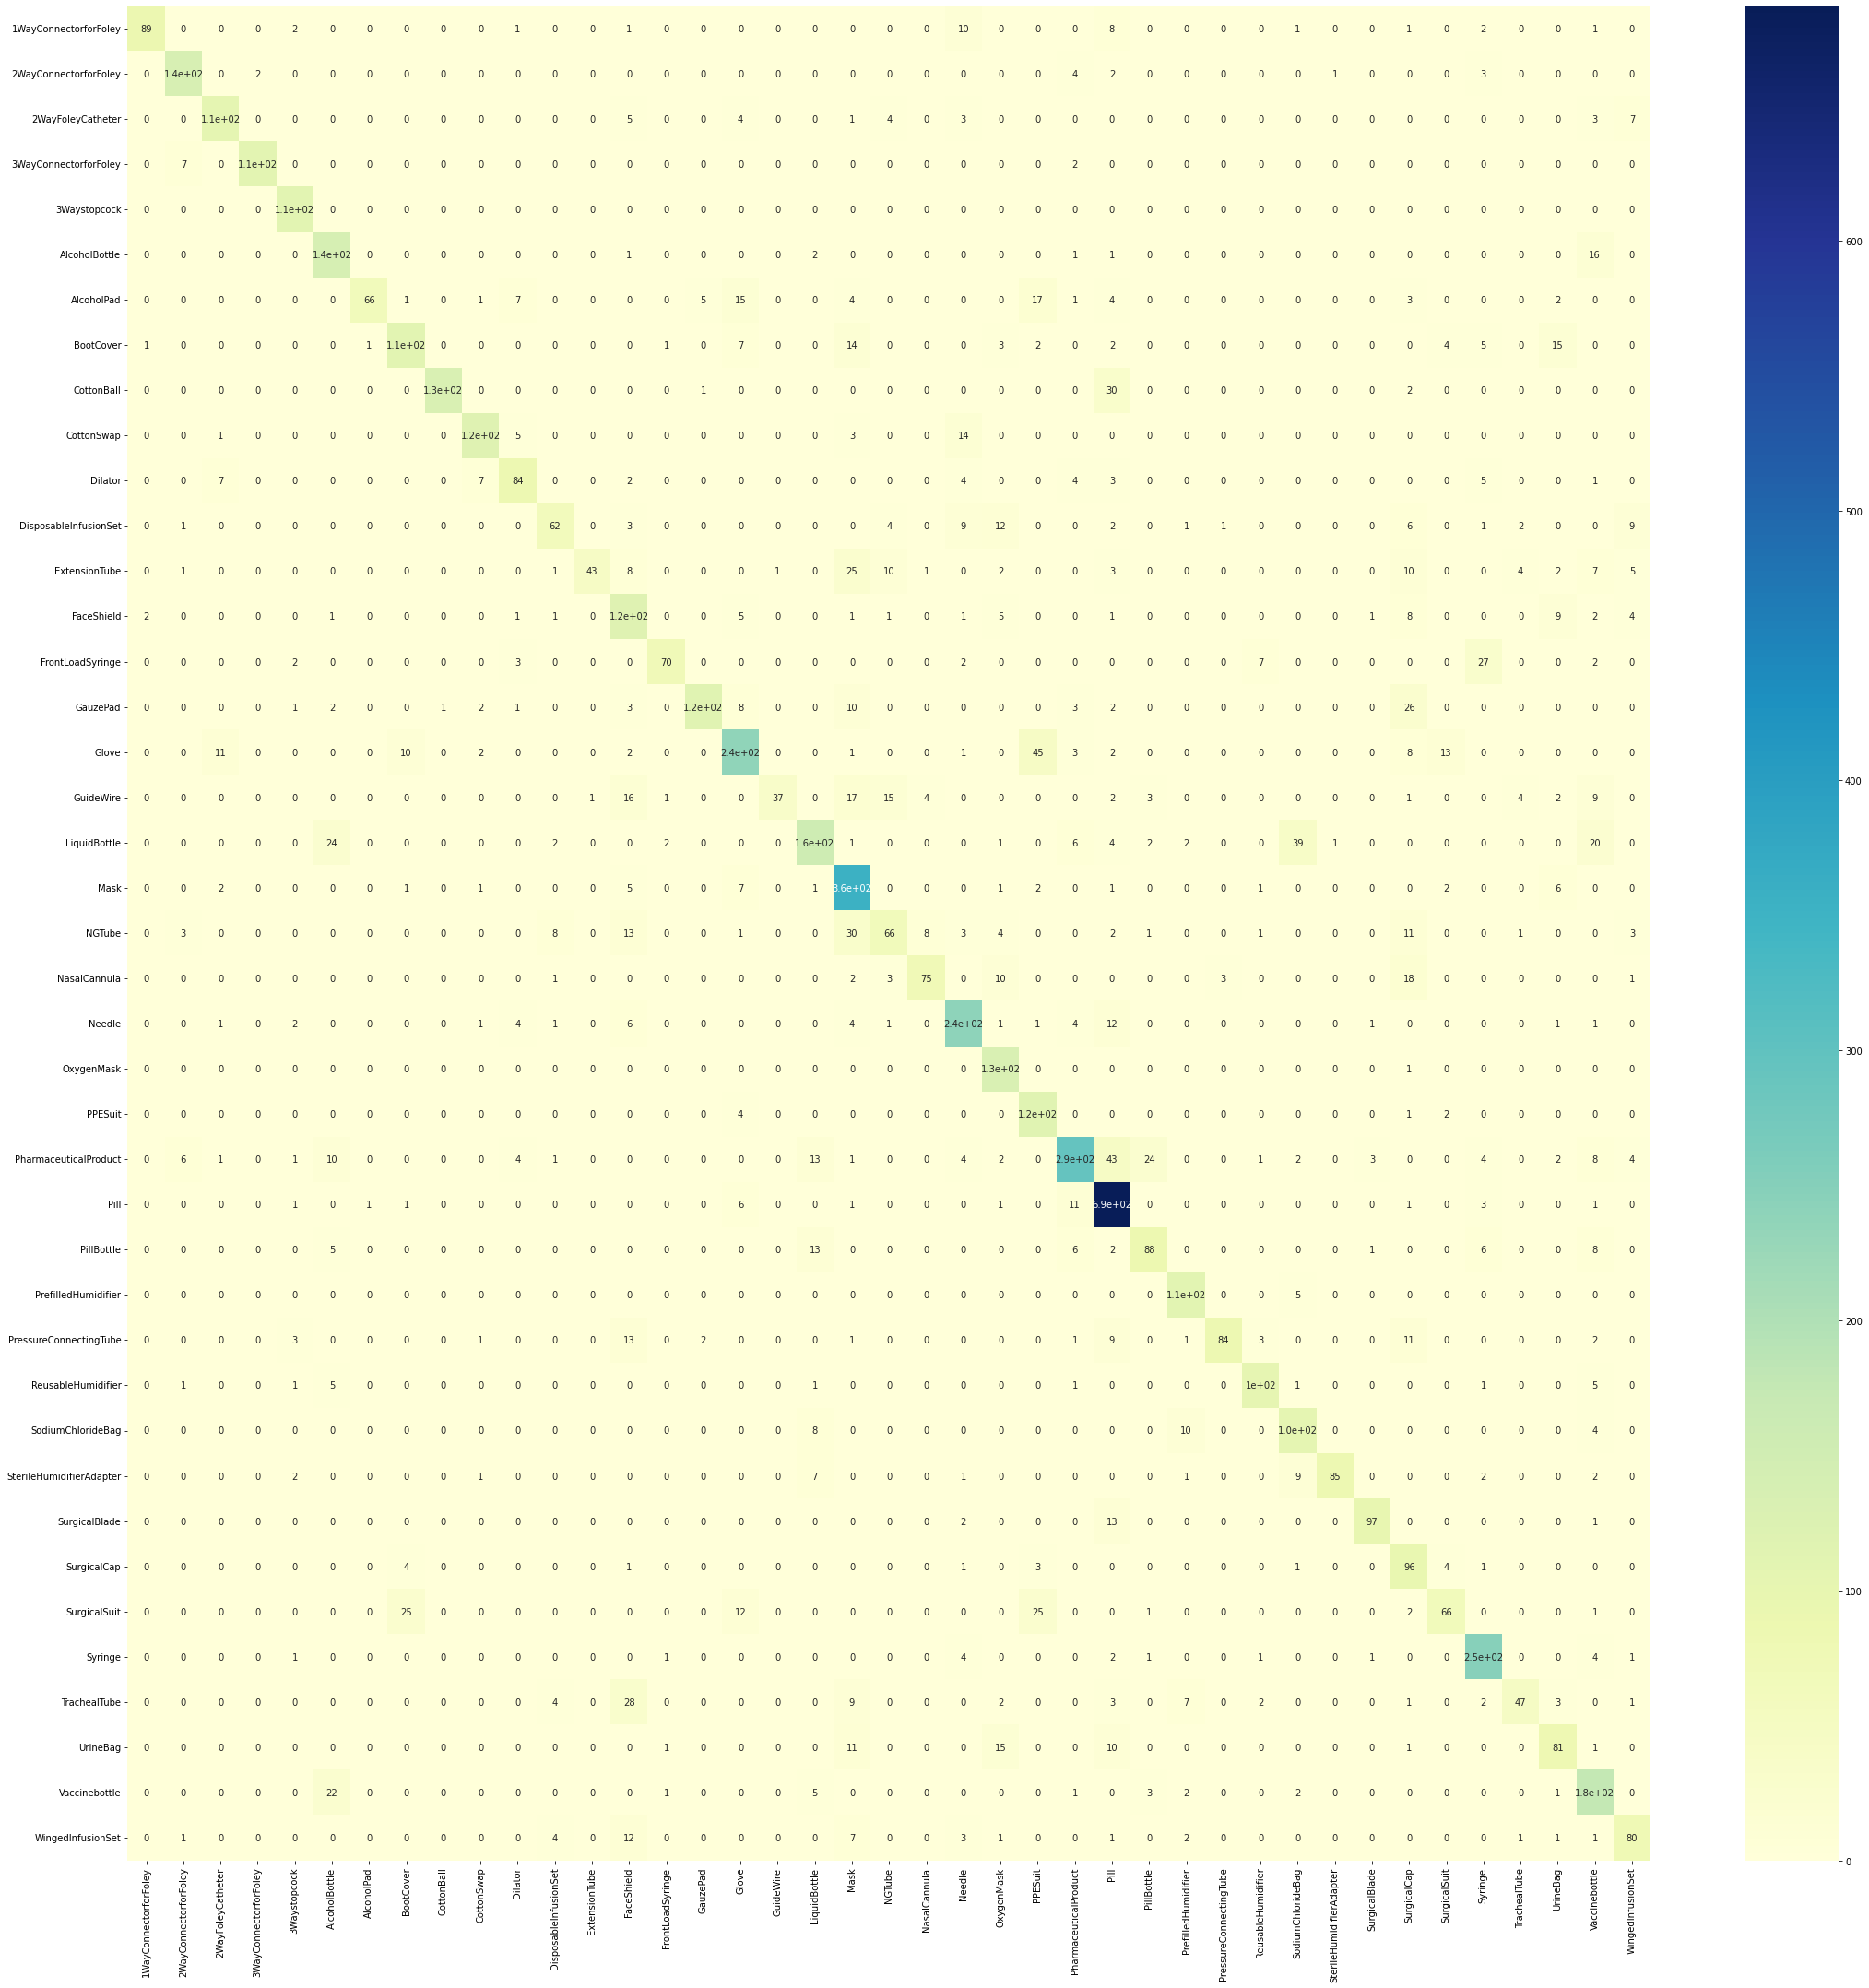

In [11]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

<AxesSubplot:>

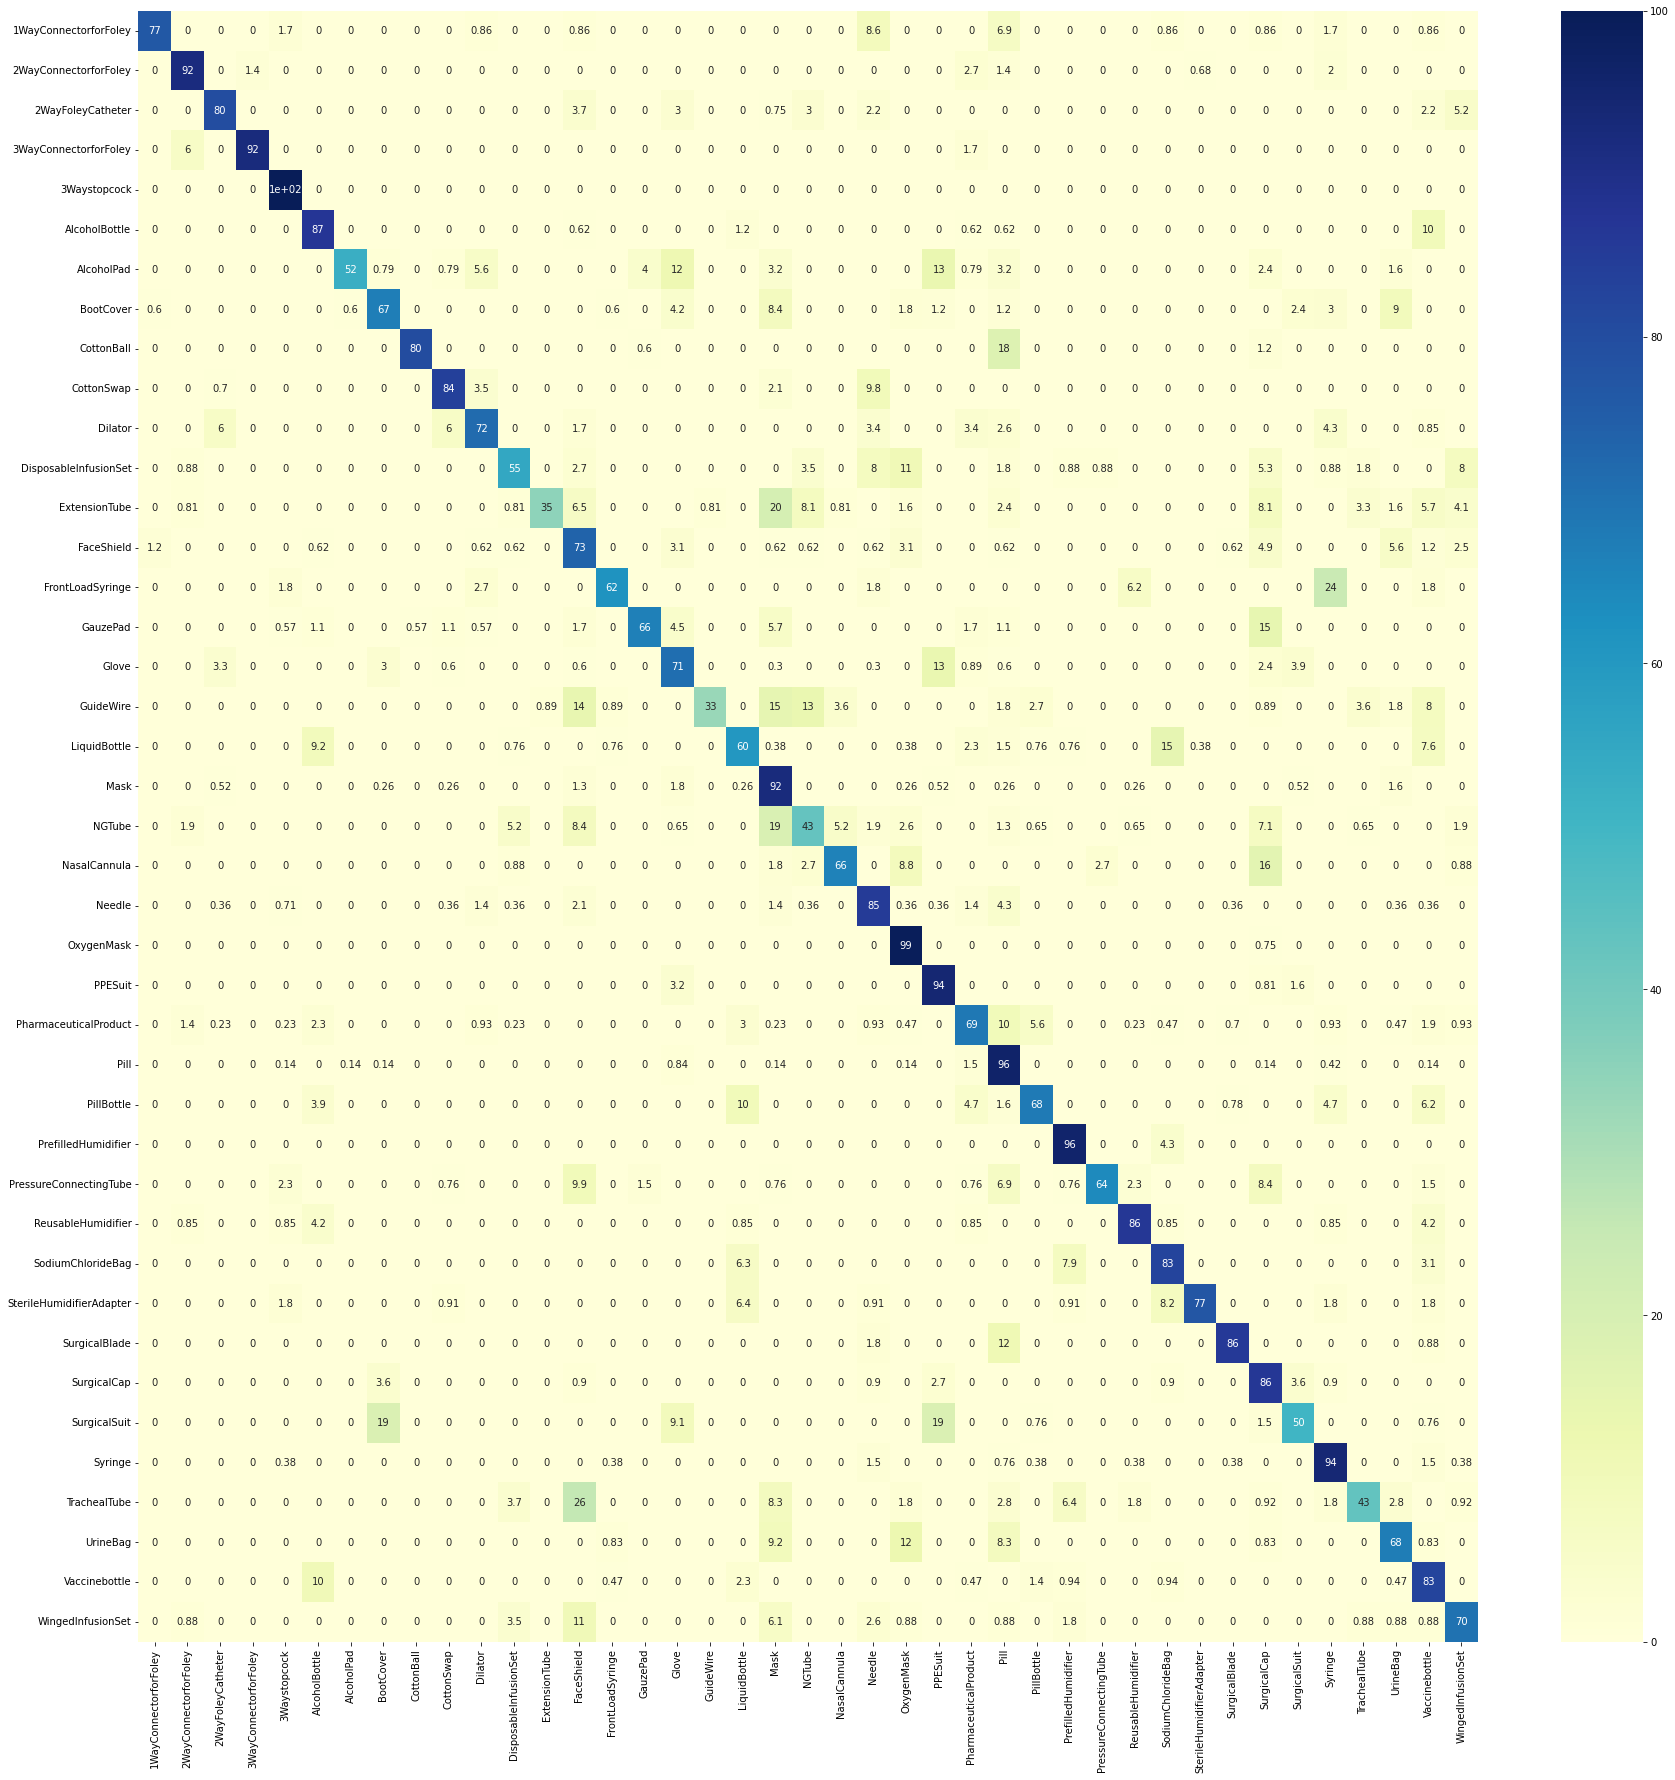

In [12]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")